In [1]:
import re
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Classification and Clustering of the coffees.
To be able to identify the coffees that match the preferences of the team it is necessary to identify some relevant features from each coffee, that will allow to recommend it to each of the members of the team.  
**Features:**
* Region of origin contains fazenda kaquend, kaquend farm, sul de minas, (minas gerais with sul de minas)
* Sweet: using the `Sweetness` column
* Very Sweet: using the `Sweetness` column
* Not too strong: Robusta is known for being the strongest species
* Soft: Low values of `Body` can be associated with softer coffees (less oily texture)
* No aroma: Using the `Aroma` column
* No flavor: Using the `Flavor` column

Although there is a direct score for *Acidity*, its scale varies between coffees. According to the data source (https://database.coffeeinstitute.org/coffee/976032/grade), this scores will vary depending on the origin or type of coffee. This means that this score *"... reflect the panelist's perceived quality for the Acidity relative to the expected flavor profile based on origin characteristics and/or other factors"*. For this reason, *Acidity* should not be compared among coffees from different regions/types.

Regarding the Soft/Not too strong preferences, we can observe that in general coffees with smaller values of *Body* preserve less oils and are considered light or Soft. (https://espressocoffeeguide.com/all-about-coffee-2/coffee-flavor/body/). 

Sumatra is known for heavier body, Yemen Mocha for medium to heavy and Mexican for a lighter body. The correlation matrix below shows that higher values of `Moisture` are associated with low `Body`. Also, `Balance`, `Flavor` and `Aftertaste` are positively correlated with `Body`, therefore, lower values of this columns are preferred for a Soft coffee.

Finally, is worth mentioning that although the coffee from Fazenda Kaquend is a great indicator for Marcio's taste, **the model will not necessarily recommend this coffee in case it is not part of the cluster selected as the most representative for the Sul de Minas region**, however, its features will be considered when selecting the ones that are recommended.

In [2]:
full_df = pd.read_csv('arabica_robusta_cleaned.csv')

In [4]:
selection = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
             'Balance', 'Uniformity', 'Clean.Cup', 'Sweetness',
             'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 
             'Quakers','altitude_mean_meters']

selected_df = full_df[selection]

corr = selected_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,altitude_mean_meters
Aroma,1,0.83,0.79,0.75,0.72,0.73,0.4,0.36,0.27,0.8,-0.076,-0.083,0.0072,0.13
Flavor,0.83,1,0.89,0.84,0.78,0.81,0.44,0.43,0.3,0.88,-0.11,-0.06,0.0074,0.13
Aftertaste,0.79,0.89,1,0.8,0.78,0.82,0.44,0.43,0.28,0.87,-0.14,-0.083,0.0056,0.12
Acidity,0.75,0.84,0.8,1,0.75,0.75,0.42,0.33,0.27,0.81,-0.093,-0.072,0.012,0.15
Body,0.72,0.78,0.78,0.75,1,0.81,0.4,0.32,0.26,0.79,-0.14,-0.029,-0.0046,0.11
Balance,0.73,0.81,0.82,0.75,0.81,1,0.43,0.39,0.29,0.84,-0.17,-0.064,0.0084,0.12
Uniformity,0.4,0.44,0.44,0.42,0.4,0.43,1,0.52,0.48,0.68,-0.014,-0.11,0.033,0.033
Clean.Cup,0.36,0.43,0.43,0.33,0.32,0.39,0.52,1,0.45,0.68,-0.035,-0.13,0.033,0.044
Sweetness,0.27,0.3,0.28,0.27,0.26,0.29,0.48,0.45,1,0.56,0.055,-0.018,0.0051,0.011
Total.Cup.Points,0.8,0.88,0.87,0.81,0.79,0.84,0.68,0.68,0.56,1,-0.1,-0.098,0.014,0.11


The correlation matrix for some selected numeric features is displayed above. It is observed that the Total.Cup.Points is highly correlated with all the individual measurements as expected, because it is calculated as the sum of all these scores.  
As explained before, the *Acidity* score presents a behavior that is difficult to quantify because for coffees with very different levels of acidity a high score can be recorded. This happens because depending on the origin of the coffee, it can have a high score regardless of the actual value of acidity, as long as it matches with its expected level of it. For this reason, *Acidity* is not considered in the model, but the Total.Cup.Points will remain in the model, considering that algorithms that rely on distance for clustering can handle these correlated variables well.

The approach to be implemented will consist in finding the best fit of 2 different clustering algorithms, K-means and Hierarchical clustering (agglomerative). 

#### Scaling the data
Taking into consideration that the clustering algorithms to be used make use of distance between the observations to find the more dense regions and assign clusters to them, it is important to scale the data so no features are given more/less relevance due to different scales. 



In [5]:
import sklearn
from sklearn.preprocessing import StandardScaler

filt_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Body', 'Balance', 
             'Uniformity', 'Clean.Cup', 'Sweetness', 
             'Total.Cup.Points', 'Moisture', 'Category.One.Defects', 
             'Quakers','altitude_mean_meters']

# Get a df of the selected columns and avoiding any null values 
selected_df = full_df[filt_cols][~pd.isnull(full_df[filt_cols]).any(axis=1)].copy()
selected_df.shape # 231 observations contain nan's in the altitude and are lost 

(1242, 13)

In [6]:
# Scale the data
train_data = StandardScaler().fit_transform(selected_df)
train_data.shape

(1242, 13)

#### K-Means
One of the main challenges of using K-Means, is to determine an adequate number of clusters. Silhouette analysis can be used to study the separation distance between the resulting clusters, and to decide the best number of K to be used.  
<strong>From documentation:</strong> <i>"The Silhouette Coefficient is calculated using the mean intra-cluster distance (``a``) and the mean nearest-cluster distance (``b``) for each sample.  The Silhouette Coefficient for a sample is ``(b - a) / max(a,b)``.  To clarify, ``b`` is the distance between a sample and the nearest cluster that the sample is not a part of."</i>

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(train_data)
    
    silhouette_avg = silhouette_score(train_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.9309541290846407
For n_clusters = 3 The average silhouette_score is : 0.21515608429243194
For n_clusters = 4 The average silhouette_score is : 0.20122397290129665
For n_clusters = 5 The average silhouette_score is : 0.2117842936718094
For n_clusters = 6 The average silhouette_score is : 0.21583134474118246
For n_clusters = 7 The average silhouette_score is : 0.1924932445333667
For n_clusters = 8 The average silhouette_score is : 0.20787640245720387
For n_clusters = 9 The average silhouette_score is : 0.15327712494166332
For n_clusters = 10 The average silhouette_score is : 0.21187872025358143


Since the best score was obtained with 2 clusters, this value is used for the model and the graph of the clusters frequency is displayed below

In [8]:
# Use KMeans with the n_clusters with the best silhouette score
clusterer = KMeans(n_clusters=2, algorithm='full', random_state=10)
cluster_labels = clusterer.fit_predict(train_data)

kmeans_df = full_df[~pd.isnull(full_df[filt_cols]).any(axis=1)].copy()
kmeans_df['cluster'] = cluster_labels

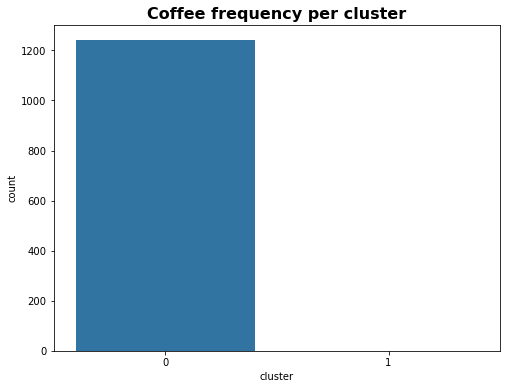

In [9]:
brazil_list = ['south of minas', 'sul de minas - carmo de minas', 
               'sul de minas', 'sul de minas gerais'] #'mountains of minas gerais','minas gerais, br', 

# dataframe with the coffees from sul de minas
sul_minas_df = kmeans_df[kmeans_df['Region'].isin(brazil_list)]

plt.figure(figsize=(8, 6))
g = sns.countplot(x=kmeans_df.cluster, data=kmeans_df)
plt.title('Coffee frequency per cluster',size=16, fontdict={'weight':'bold'})
plt.show()

Using the best silhouette score is not useful, as all the data is assigned to a single cluster. Below are the results for a different number of clusters, and the second plot is particularly relevant because it corresponds to the distribution of the 'Sul de Minas' coffees among the different clusters. Since the use of the silhouette score was not giving good results for finding k, the decision of 5 clusters was because it was presenting a better distribution among clusters, although for clusters 2 and 4, the number of coffees assigned to them is considerably lower. In the next section, a different algorithm will be implemented to try to get better results

In [10]:
clusterer = KMeans(n_clusters=5, algorithm='full', random_state=10)
cluster_labels = clusterer.fit_predict(train_data)

kmeans_df = full_df[~pd.isnull(full_df[filt_cols]).any(axis=1)].copy()
kmeans_df['cluster'] = cluster_labels

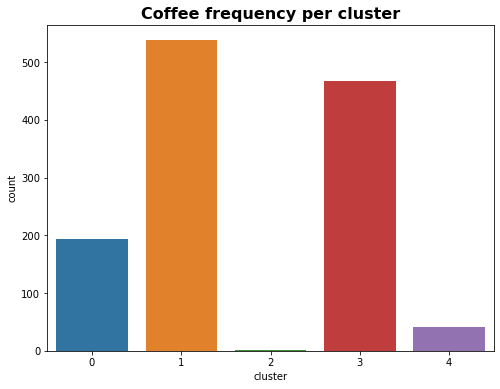

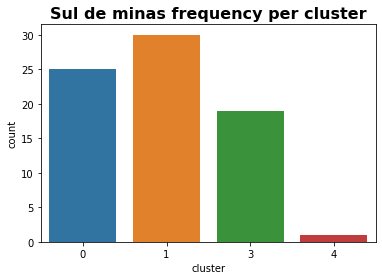

In [11]:
sul_minas_df = kmeans_df[kmeans_df['Region'].isin(brazil_list)]

plt.figure(figsize=(8, 6))
g = sns.countplot(x=kmeans_df.cluster, data=kmeans_df)
plt.title('Coffee frequency per cluster',size=16, fontdict={'weight':'bold'})
plt.show()
g = sns.countplot(x=sul_minas_df.cluster, data=sul_minas_df)
plt.title('Sul de minas frequency per cluster',size=16, fontdict={'weight':'bold'})
plt.show()

Using 5 clusters it is observed that the cluster 2 is almost empty and cluster 4 is very small. However, the second graph where the Sul de Minas coffees are displayed, shows that cluster 0, which initially is considerably smaller when compared to 2 and 3, is now the second in size and is very close to the size of cluster 1. This can be interpreted as cluster 0 being highly relevant to the taste of Marcio and Rafa, as it contains a smaller selection of coffees where the Brazilian ones have a bigger proportion.

In [12]:
cluster_counts = kmeans_df.groupby('cluster').agg(count = ('cluster','count'))
brazil_counts = sul_minas_df.groupby('cluster').agg(counts = ('cluster','count'))
cluster_counts['brazilian_count'] = brazil_counts.counts
cluster_counts['perc'] = cluster_counts['brazilian_count']/cluster_counts['count']
cluster_counts.sort_values('perc',ascending=False)

,count,brazilian_count,perc
cluster,,,
0,194,25.0,0.128866
1,538,30.0,0.055762
3,468,19.0,0.040598
4,41,1.0,0.024390
2,1,NaN,NaN


The table above shows the percentage that *'Sul de Minas'* coffees represent among each cluster. This score will be used to determine which algorithm produces the best cluster to recommend coffees for Marcio and Rafa since they have a strong preference for coffees from this region

#### Hierarchical clustering (agglomerative)

In [13]:
from sklearn.cluster import AgglomerativeClustering

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='average', affinity='cosine')
    cluster_labels = clusterer.fit_predict(train_data)
    
    silhouette_avg = silhouette_score(train_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.162109739168874
For n_clusters = 3 The average silhouette_score is : 0.16316032898334745
For n_clusters = 4 The average silhouette_score is : 0.17523793425606463
For n_clusters = 5 The average silhouette_score is : 0.1810540593004644
For n_clusters = 6 The average silhouette_score is : 0.17220029517939694
For n_clusters = 7 The average silhouette_score is : 0.17790659218420013
For n_clusters = 8 The average silhouette_score is : 0.11894603692854822
For n_clusters = 9 The average silhouette_score is : 0.08626212973939541
For n_clusters = 10 The average silhouette_score is : 0.08598712864402314


In [14]:
# Agglomerative clustering with average linkage is producing more evenly distributed clusters
clusterer = AgglomerativeClustering(n_clusters=5, linkage='average', affinity='cosine')
cluster_labels = clusterer.fit_predict(train_data)

agglom_df = full_df[~pd.isnull(full_df[filt_cols]).any(axis=1)].copy()
agglom_df['cluster'] = cluster_labels

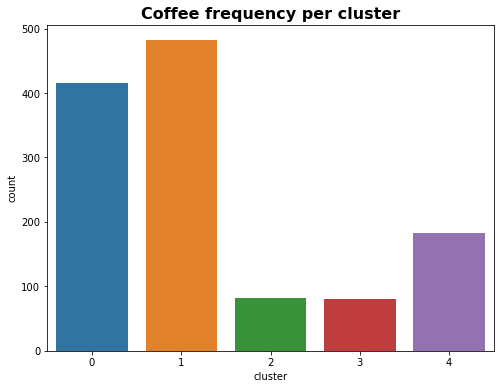

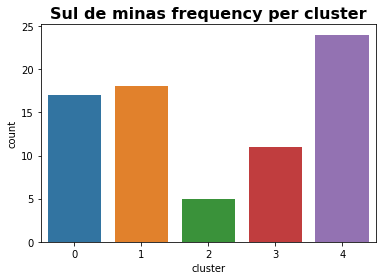

In [15]:
sul_minas_df = agglom_df[agglom_df['Region'].isin(brazil_list)]
plt.figure(figsize=(8, 6))
g = sns.countplot(x=agglom_df.cluster, data=agglom_df)
plt.title('Coffee frequency per cluster',size=16, fontdict={'weight':'bold'})
plt.show()
g = sns.countplot(x=sul_minas_df.cluster, data=sul_minas_df)
plt.title('Sul de minas frequency per cluster',size=16, fontdict={'weight':'bold'})
plt.show()

Using agglomerative clustering and euclidean metric produced a similar result with the silhouette score suggesting 2 clusters. However, when using cosine similarity, the suggested number of clusters was 5 and they seem to be better distributed than using k-means. Also in the table below, the metric of the percentage (perc) that the *'Sul de Minas'* coffees represent from each clusters show a higher value using this algorithm.

In [16]:
cluster_counts = agglom_df.groupby('cluster').agg(count = ('cluster','count'))
brazil_counts = sul_minas_df.groupby('cluster').agg(counts = ('cluster','count'))
cluster_counts['brazilian_count'] = brazil_counts.counts
cluster_counts['perc'] = cluster_counts['brazilian_count']/cluster_counts['count']
cluster_counts.sort_values('perc',ascending=False)

,count,brazilian_count,perc
cluster,,,
3,80,11,0.137500
4,183,24,0.131148
2,82,5,0.060976
0,415,17,0.040964
1,482,18,0.037344


#### Hierarchical clustering (agglomerative) using `distance_threshold`

In [17]:
# distance_th is the linkage distance above which, clusters will not be merged
clusterer = AgglomerativeClustering(n_clusters=None, linkage='average', affinity='cosine',
                                    compute_full_tree=True, distance_threshold=0.9) 
cluster_labels = clusterer.fit_predict(train_data)

agglom_df = full_df[~pd.isnull(full_df[filt_cols]).any(axis=1)].copy()
agglom_df['cluster'] = cluster_labels

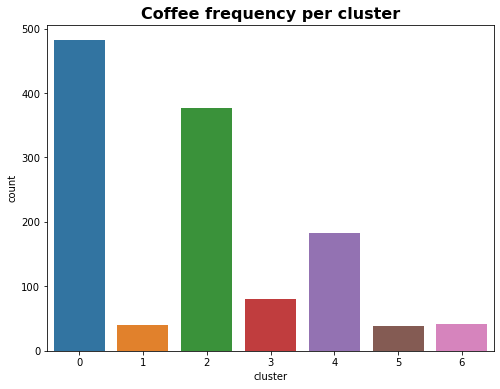

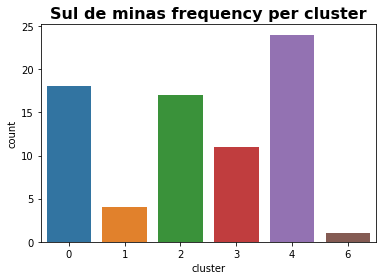

In [18]:
sul_minas_df = agglom_df[agglom_df['Region'].isin(brazil_list)]
plt.figure(figsize=(8, 6))
g = sns.countplot(x=agglom_df.cluster, data=agglom_df)
plt.title('Coffee frequency per cluster',size=16, fontdict={'weight':'bold'})
plt.show()
g = sns.countplot(x=sul_minas_df.cluster, data=sul_minas_df)
plt.title('Sul de minas frequency per cluster',size=16, fontdict={'weight':'bold'})
plt.show()

Finally, a variation of agglomerative clustering was used using the `distance_threshold` parameter, which sets a limit for merging clusters. In this way, the number of clusters is determined by the algorithm. The results are similarly good compared to the previous case. 

In [19]:
cluster_counts = agglom_df.groupby('cluster').agg(count = ('cluster','count'))
brazil_counts = sul_minas_df.groupby('cluster').agg(counts = ('cluster','count'))
cluster_counts['brazilian_count'] = brazil_counts.counts
cluster_counts['perc'] = cluster_counts['brazilian_count']/cluster_counts['count']
cluster_counts.sort_values('perc',ascending=False)

,count,brazilian_count,perc
cluster,,,
3,80,11.0,0.137500
4,183,24.0,0.131148
1,40,4.0,0.100000
2,377,17.0,0.045093
0,482,18.0,0.037344
6,42,1.0,0.023810
5,38,NaN,NaN


#### Model selection
The last method of Hierarchical clustering (agglomerative) produced the highest participation of the *'Sul de Minas'* coffees in a single cluster. Thus, the agglomerative approach is selected over K-means and the **cluster 3**, which is the one with the highest percentage of *'Sul de Minas'* coffees, is selected to recommend the top5 coffees for Marcio and Rafa.

#### Recommendations for Marcio & Rafa
Since the main criteria for both, Marcio and Rafa, is to have coffees that are similar to those from "Sul de Minas" in Brazil, we will focus on the cluster containing the highest proportion of them. After determining the cluster, we will find the mean value that represents those from *Fazenda Kaquend* and **compute the closest 5 coffees** to this "centroid". We will recommend them and add a constraint of having **maximum 2 coffees that are not from Brazil**, as a way to suggest a coffee from a different region that is still close to the characteristics of those from "Sul de Minas", but without ignoring the fact that Marcio and Rafa have a strong preference for Brazilian coffees.

**The cluster to be considered for the recommendations is Cluster 3**

In [20]:
# Find the indexes of all fazenda kaquend coffees in the dataframe
idx_kaquend = agglom_df[(~pd.isna(agglom_df['Farm.Name']))&
          (agglom_df['Farm.Name'].str.contains('kaquend'))].index

# Create a consecutive index that matches with the one of train_data
agglom_df['train_idx'] = list(range(0, train_data.shape[0]))

# map the indexes from the dataframe to the train_data
idx_kaquend = list(agglom_df.loc[idx_kaquend,'train_idx'])

# stack all the features of fazenda kaquend coffees 
kaquend_array = np.zeros(shape=(1,train_data.shape[1]))
for i in idx_kaquend:
    kaquend_array = np.vstack((kaquend_array, train_data[i]))
    
kaquend_centroid = kaquend_array.mean(axis=0)

In [21]:
# Find the indexes of all coffees in cluster 3
idx_clust3 = agglom_df[(agglom_df['cluster'] == 3)].index

# map the indexes from the dataframe to the train_data
idx_clust3 = list(agglom_df.loc[idx_clust3,'train_idx'])

dist_array = np.array([idx_clust3]).T
dist_array = np.hstack((dist_array, np.zeros(shape=(len(idx_clust3),1))))

for i, dist_idx in enumerate(dist_array):
    distance = np.linalg.norm(train_data[int(dist_idx[0])] - kaquend_centroid)
    dist_array[i,1] = distance

In [22]:
# get indexes of the sorted distances
sort_idx = dist_array.argsort(axis=0)[:][:,1]

# get train_idx of the sorted distances found above
sort_idx = dist_array[sort_idx,0]

recomm_list = []
foreign_count = 0
position_dict = {}
position = 1
# get the coffees to be recommended
for coffee_idx in sort_idx:
    country = agglom_df[agglom_df['train_idx'] == coffee_idx]['Country.of.Origin'].values[0]
    if (country == 'Brazil'):
        recomm_list.append(coffee_idx)
        position_dict[coffee_idx] = position
        position += 1
    elif (foreign_count < 2):
        recomm_list.append(coffee_idx)
        foreign_count += 1
        position_dict[coffee_idx] = position
        position += 1
    if len(recomm_list) >= 5: break

In [23]:
recomm_df = agglom_df[agglom_df['train_idx'].isin(recomm_list)].copy()
recomm_df.insert(1, 'Ranking', 0)
recomm_df['Ranking'] = recomm_df['train_idx'].map(position_dict)
recomm_df = recomm_df.sort_values(by=['Ranking'])
recomm_df

,Unnamed: 0,Ranking,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,...,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,altitude_low_meters,altitude_high_meters,altitude_mean_meters,cluster,train_idx
1142,1375,1,Arabica,byron gonzalez,Guatemala,alta luz,415000544,NaN,11-63-1073,"retrillas del pacifico, s. a.",...,1.0,Green,5 full defects,"July 20th, 2021",Asociacion Nacional Del Café,1400.0,1400.0,1400.0,3,1141
1136,1369,2,Arabica,angelica paola citan lopez,Guatemala,finca beneficio el torreon,11/23/267,beneficio ixchel,11/23/267,asociación nacional del cafe,...,1.0,Green,4 full defects,"March 19th, 2022",Asociacion Nacional Del Café,1901.0,1901.0,1901.0,3,1135
209,262,3,Arabica,ipanema coffees,Brazil,capoeirinha,007/16E,dry mill,002/1660/0105,ipanema coffees,...,2.0,Green,7,"August 16th, 2017",Brazil Specialty Coffee Association,934.0,934.0,934.0,3,209
256,319,4,Arabica,ipanema coffees,Brazil,capoeirinha,008/16A,dry mill,002/1660/0106,ipanema coffees,...,2.0,Green,3,"August 16th, 2017",Brazil Specialty Coffee Association,934.0,934.0,934.0,3,256
391,481,5,Arabica,ipanema coffees,Brazil,capoeirinha,261/15,dry mill,002/1660/0049,ipanema coffees,...,2.0,Bluish-Green,2,"April 25th, 2017",Brazil Specialty Coffee Association,905.0,905.0,905.0,3,390


<Figure size 1152x720 with 0 Axes>

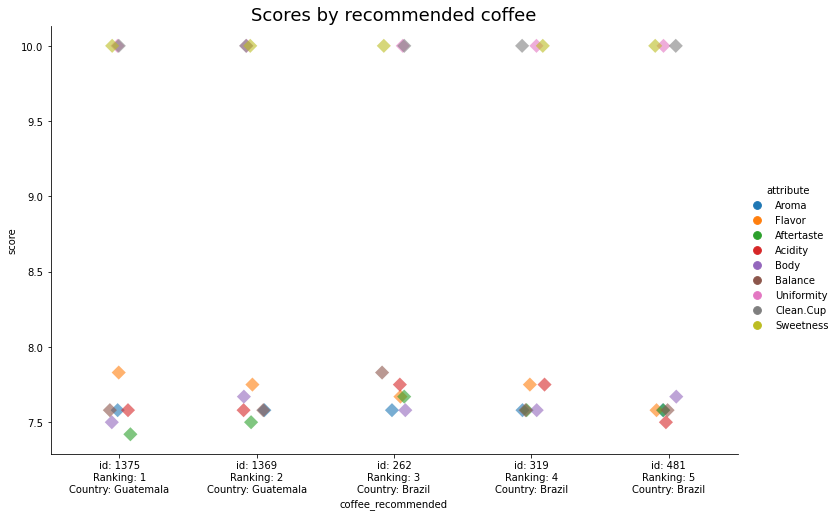

In [24]:
plt.figure(figsize = (16, 10))

df = recomm_df.iloc[:,[0,1,4]+list(range(20,29))].copy()
df['coffee_recommended'] = ('id: ' + df['Unnamed: 0'].astype(str) + \
                            '\nRanking: ' + df['Ranking'].astype(str) +\
                            '\nCountry: ' + df['Country.of.Origin'].astype(str))

df.drop(['Unnamed: 0','Ranking','Country.of.Origin'], axis=1, inplace=True)
df = df.melt('coffee_recommended', var_name='attribute',  value_name='score')

g = sns.catplot(x='coffee_recommended', y='score', hue='attribute', data=df, 
                height=7, aspect=1.5, s=10, kind='strip', alpha=0.6, marker='D')
plt.title("Scores by recommended coffee", size=18)
plt.show()

In [25]:
agglom_df[agglom_df['Farm.Name']=='fazenda kaquend'].iloc[:5,19:30]

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Total.Cup.Points,Moisture
21,8.50,8.5,8.0,8.0,8.00,8.0,10.0,10.0,10.0,86.92,0.12
35,8.33,8.0,8.0,8.0,7.75,8.0,10.0,10.0,10.0,86.08,0.11


##### Conclusion Marcio & Rafa
The profile of the top5 coffees recommended for Marcio and Rafa can be seen above. The first 2 recommendations are from Guatemala and the rest are from Brazil, and according to the logic behind the model, these coffees represent the most similar coffees to those from *'Sul de Minas'*. In addition to this, the recommended coffees are also the closest to *'Fazenda Kaquend'* among all the *'Sul de Minas'* cluster. The table above shows the scores for fazenda kaquend as a reference.

#### Recommendations for Subu

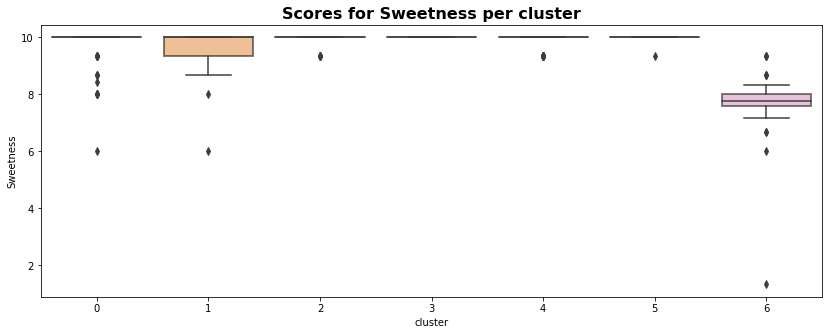

In [26]:
plt.figure(figsize = (14, 5))

# Remove a record which contains only 0 values in the scores, train_idx 1078
agglom_df = agglom_df[agglom_df['Total.Cup.Points'] > 0]

ax = sns.boxplot(x='cluster', y='Sweetness', data=agglom_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
ax.set_title('Scores for Sweetness per cluster', fontsize=16, fontdict={"weight": "bold"})
plt.show()

Unlike James, Subu goes for sweet instead of very sweet taste. From the graph above we can see that the **cluster 1** fits that description, presenting high level of *Sweetness* but not as much as the other clusters. **Cluster 6** presents the lowest levels of *Sweetness* and would be an interesting option for someone with that taste, since is the only cluster with that characteristic. 

According to the Sweetness feature, we can only **discard cluster 6** and have a **slight preference for cluster 1**. The next graph to consider is Flavor, where we look for lower values because Subu prefers <i>"Not to strong flavor"</i>

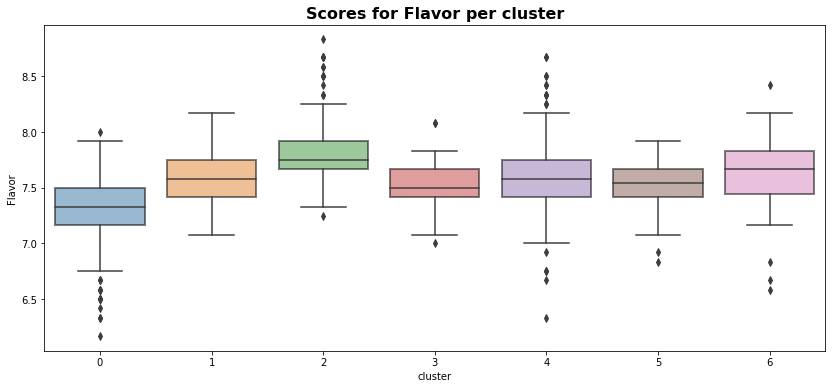

In [27]:
plt.figure(figsize = (14, 6))
ax = sns.boxplot(x='cluster', y='Flavor', data=agglom_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
ax.set_title('Scores for Flavor per cluster', fontsize=16, fontdict={"weight": "bold"})
plt.show()

Above it is observed that **cluster 0** and **cluster 3** present the lower median scores for Flavor, with **cluster 3** having less variability. However, **cluster 1** which was slightly better from the *Sweetness* perspective, presents a value similar to **cluster 3** with just a slightly higher median, but most of the box (50% of the data) is within a very similar region. Since Subu's preference is for a not too strong *Flavor* we will go for **cluster 1** as the best cluster to give a recommendation to Subu.

Finally, **the top 5 coffees that we will recommend to Subu will be those closest to the median of both, *Sweetness* and *Flavor* among this cluster.**

In [28]:
clust1_sweet_med = agglom_df[(agglom_df['cluster'] == 1)]['Sweetness'].median()
clust1_flavor_med = agglom_df[(agglom_df['cluster'] == 1)]['Flavor'].median()
centroid_subu = np.array([clust1_flavor_med, clust1_sweet_med])

# Find the indexes of all coffees in cluster 1
idx_clust1 = agglom_df[(agglom_df['cluster'] == 1)].index

# map the indexes from the dataframe to the train_data
idx_clust1 = list(agglom_df.loc[idx_clust1,'train_idx'])

dist_array = np.array([idx_clust1]).T
dist_array = np.hstack((dist_array, np.zeros(shape=(len(idx_clust1),1))))

for i, dist_idx in enumerate(dist_array):
    distance = np.linalg.norm(train_data[int(dist_idx[0]),[1,7]] - centroid_subu)
    dist_array[i,1] = distance

In [29]:
# get indexes of the sorted distances
sort_idx = dist_array.argsort(axis=0)[:][:,1]

# get train_idx of the sorted distances found above
sort_idx = dist_array[sort_idx,0]

recomm_list = []
foreign_count = 0
position_dict = {}
position = 1
# get the coffees to be recommended
for coffee_idx in sort_idx:
    country = agglom_df[agglom_df['train_idx'] == coffee_idx]['Country.of.Origin'].values[0]
    if (country == 'Brazil'):
        recomm_list.append(coffee_idx)
        position_dict[coffee_idx] = position
        position += 1
    elif (foreign_count < 3):
        recomm_list.append(coffee_idx)
        foreign_count += 1
        position_dict[coffee_idx] = position
        position += 1
    if len(recomm_list) >= 5: break

In [30]:
# Create the dataframe with the final recommendations for Subu
recomm_df2 = agglom_df[agglom_df['train_idx'].isin(recomm_list)].copy()
recomm_df2.insert(1, 'Ranking', 0)
recomm_df2['Ranking'] = recomm_df2['train_idx'].map(position_dict)
recomm_df2 = recomm_df2.sort_values(by=['Ranking'])
recomm_df2

,Unnamed: 0,Ranking,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,...,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,altitude_low_meters,altitude_high_meters,altitude_mean_meters,cluster,train_idx
494,602,1,Arabica,romulo bello flores,Mexico,NaN,NaN,NaN,1302910536,cafe shunuc,...,0.0,NaN,4,"June 6th, 2013",AMECAFE,1200.0,1200.0,1200.0,1,493
452,556,2,Arabica,veronica lopez castillejos,Mexico,el jabali,NaN,comunidad la cumbre,1489,union de ejidos san fernando de ri,...,0.0,Green,4,"March 5th, 2013",AMECAFE,1400.0,1400.0,1400.0,1,451
424,520,3,Arabica,santiago solis ayerdi,Mexico,finca la estancia,NaN,"atoyac de alvarez, guerrero",1302911347,finca la estancia,...,0.0,Green,7,"July 26th, 2013",AMECAFE,1200.0,1200.0,1200.0,1,423
584,713,4,Arabica,ipanema coffees,Brazil,rio verde,NaN,ipanema coffees,002/1660/0107,ipanema coffees,...,0.0,Green,0,"October 7th, 2016",Specialty Coffee Association,1268.0,1268.0,1268.0,1,583
894,1076,5,Arabica,jacques pereira carneiro,Brazil,pereira estate coffee,NaN,carapina armazens gerais,002/135-2/0182,exportadora de cafés carmo de minas ltda,...,0.0,None,10,"April 17th, 2015",Specialty Coffee Association,1250.0,1250.0,1250.0,1,893


<Figure size 1152x720 with 0 Axes>

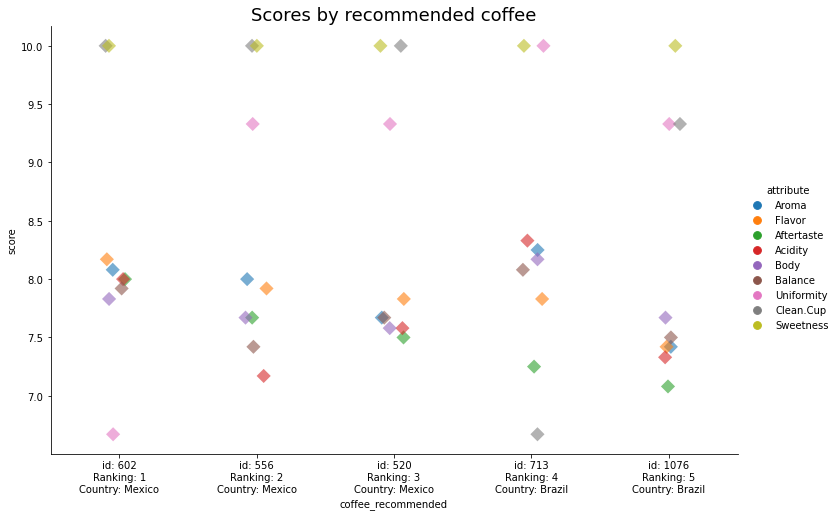

In [31]:
plt.figure(figsize = (16, 10))

df = recomm_df2.iloc[:,[0,1,4]+list(range(20,29))].copy()
df['coffee_recommended'] = ('id: ' + df['Unnamed: 0'].astype(str) + \
                            '\nRanking: ' + df['Ranking'].astype(str) +\
                            '\nCountry: ' + df['Country.of.Origin'].astype(str))

df.drop(['Unnamed: 0','Ranking','Country.of.Origin'], axis=1, inplace=True)
df = df.melt('coffee_recommended', var_name='attribute',  value_name='score')

g = sns.catplot(x='coffee_recommended', y='score', hue='attribute', data=df, 
                height=7, aspect=1.5, s=10, kind='strip', alpha=0.6, marker='D')
plt.title("Scores by recommended coffee", size=18)
plt.show()

#### Recommendations for James
For James is possible to use the previous boxplots to match his preference of <i>"Very sweet, No flavor"</i>. It is also necessary to match <i>"Soft, and No aroma"</i> preferences. For this, the *Body* and *Aroma* attributes will be used.

According to the *Sweetness* feature shown in the previous section, **cluster 1 and cluster 6 can be discarded** because they are the least sweet. Regarding the *Flavor*, the best cluster for James seems to be **cluster 0**.

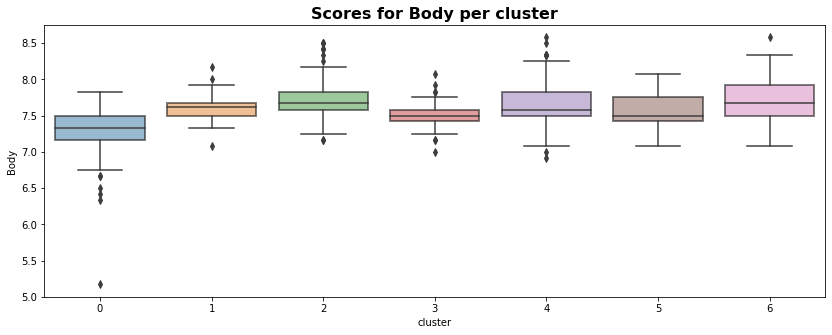

In [32]:
plt.figure(figsize = (14, 5))
ax = sns.boxplot(x='cluster', y='Body', data=agglom_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
ax.set_title('Scores for Body per cluster', fontsize=16, fontdict={"weight": "bold"})
plt.show()

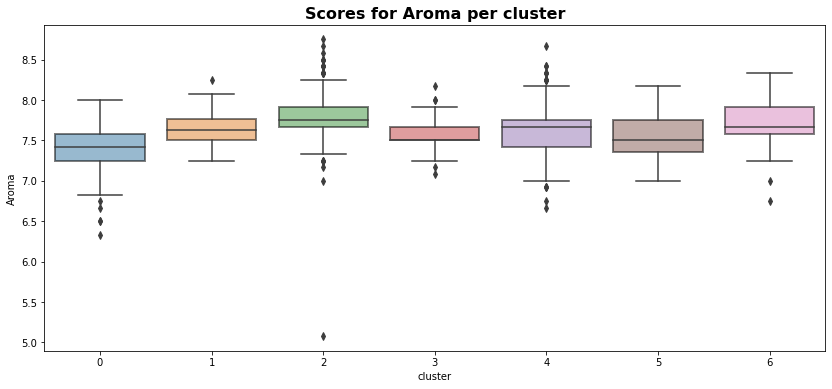

In [33]:
plt.figure(figsize = (14, 6))
ax = sns.boxplot(x='cluster', y='Aroma', data=agglom_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
ax.set_title('Scores for Aroma per cluster', fontsize=16, fontdict={"weight": "bold"})
plt.show()

The boxplots for *Body* and *Aroma* are observed above. *Body*, can be considered as an indicator of how soft the coffee is, because lower values of body can be perceived as softer (with less oily texture). There it can be seen that again **cluster 0** seems to be the most adequate as it matches better the *\"Soft and No aroma"* taste of James. For this reason **cluster 0 is selected**.

Finally, **the top 5 coffees that we will recommend to James will be those closest to the median of *Sweetness*, *Flavor*, *Body*, and *Aroma*.**

In [34]:
clust0_sweet_med = agglom_df[(agglom_df['cluster'] == 0)]['Sweetness'].median()
clust0_flavor_med = agglom_df[(agglom_df['cluster'] == 0)]['Flavor'].median()
clust0_body_med = agglom_df[(agglom_df['cluster'] == 0)]['Body'].median()
clust0_aroma_med = agglom_df[(agglom_df['cluster'] == 0)]['Aroma'].median()

centroid_james = np.array([clust0_aroma_med, clust0_flavor_med,
                           clust0_body_med, clust0_sweet_med])

# Find the indexes of all coffees in cluster 0
idx_clust0 = agglom_df[(agglom_df['cluster'] == 0)].index

# map the indexes from the dataframe to the train_data
idx_clust0 = list(agglom_df.loc[idx_clust0,'train_idx'])

dist_array = np.array([idx_clust0]).T
dist_array = np.hstack((dist_array, np.zeros(shape=(len(idx_clust0),1))))

for i, dist_idx in enumerate(dist_array):
    distance = np.linalg.norm(train_data[int(dist_idx[0]),[0,1,3,7]] - centroid_james)
    dist_array[i,1] = distance

In [35]:
# get indexes of the sorted distances
sort_idx = dist_array.argsort(axis=0)[:][:,1]

# get train_idx of the sorted distances found above
sort_idx = dist_array[sort_idx,0]

recomm_list = []
foreign_count = 0
position_dict = {}
position = 1
# get the coffees to be recommended
for coffee_idx in sort_idx:
    country = agglom_df[agglom_df['train_idx'] == coffee_idx]['Country.of.Origin'].values[0]
    if (country == 'Brazil'):
        recomm_list.append(coffee_idx)
        position_dict[coffee_idx] = position
        position += 1
    elif (foreign_count < 3):
        recomm_list.append(coffee_idx)
        foreign_count += 1
        position_dict[coffee_idx] = position
        position += 1
    if len(recomm_list) >= 5: break

In [36]:
# Get the dataframe of recommendations for James
recomm_df3 = agglom_df[agglom_df['train_idx'].isin(recomm_list)].copy()
recomm_df3.insert(1, 'Ranking', 0)
recomm_df3['Ranking'] = recomm_df3['train_idx'].map(position_dict)
recomm_df3 = recomm_df3.sort_values(by=['Ranking'])
recomm_df3

,Unnamed: 0,Ranking,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,...,Quakers,Color,Category.Two.Defects,Expiration,Certification.Body,altitude_low_meters,altitude_high_meters,altitude_mean_meters,cluster,train_idx
650,791,1,Arabica,royal base corporation,Vietnam,"apollo co., ltd.",NaN,"apollo co., ltd.",NaN,royal base corporation,...,0.0,Green,2,"July 23rd, 2013",Specialty Coffee Association,1040.00,1040.00,1040.00,0,649
171,216,2,Arabica,juan luis alvarado romero,Guatemala,chapultepec,11/23/0335,beneficio ixchel,11/23/0335,"unex guatemala, s.a.",...,0.0,Green,2,"June 1st, 2017",Asociacion Nacional Del Café,3280.00,3280.00,3280.00,0,171
333,411,3,Arabica,juan luis alvarado romero,Guatemala,el sacramento,NaN,beneficio ixchel,11/23/0419,"unex guatemala, s.a.",...,0.0,Green,3,"February 26th, 2014",Asociacion Nacional Del Café,1310.64,1310.64,1310.64,0,332
384,473,4,Arabica,nucoffee,Brazil,são francisco da serra,NaN,NaN,002/1251/0245,nucoffee,...,0.0,Green,4,"February 16th, 2013",NUCOFFEE,950.00,950.00,950.00,0,383
461,567,5,Arabica,cafebras,Brazil,santa fé 2,NaN,via seca,002/1495/0695,cafebras comercio de cafés do brasil sa,...,0.0,Green,6,"May 25th, 2016",Brazil Specialty Coffee Association,900.00,900.00,900.00,0,460


<Figure size 1152x720 with 0 Axes>

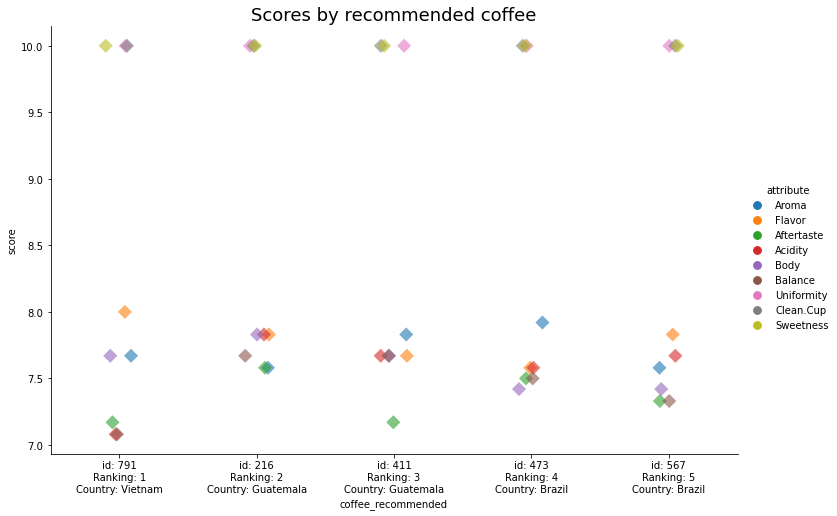

In [37]:
plt.figure(figsize = (16, 10))

df = recomm_df3.iloc[:,[0,1,4]+list(range(20,29))].copy()
df['coffee_recommended'] = ('id: ' + df['Unnamed: 0'].astype(str) + \
                            '\nRanking: ' + df['Ranking'].astype(str) +\
                            '\nCountry: ' + df['Country.of.Origin'].astype(str))

df.drop(['Unnamed: 0','Ranking','Country.of.Origin'], axis=1, inplace=True)
df = df.melt('coffee_recommended', var_name='attribute',  value_name='score')

g = sns.catplot(x='coffee_recommended', y='score', hue='attribute', data=df, 
                height=7, aspect=1.5, s=10, kind='strip', alpha=0.6, marker='D')
plt.title("Scores by recommended coffee", size=18)
plt.show()

### PCA visualization
In order to have an idea of the obtained clusters, PCA will be used to reduce the dimensionality into 2 principal components, which will allow to visualize the data. The results below show that the first components explain just below 50% of the variation in the data, which means that still there is a lot left unexplained by this first 2 components, however, it is a way to visualize how the hierarchical clustering is grouping the data.

In [38]:
from sklearn.decomposition import PCA

pca_coffee = PCA(n_components=2)
train_data = np.delete(train_data, 1078, axis=0) # remove idx 1078 which was removed previously
princ_components = pca_coffee.fit_transform(train_data)

pca_df = pd.DataFrame(data = princ_components, 
                      columns = ['princ_comp1', 'princ_comp2'])

In [39]:
print('Explained variation per principal component: {}'.format(pca_coffee.explained_variance_ratio_))

Explained variation per principal component: [0.3310197  0.12730694]


<Figure size 432x288 with 0 Axes>

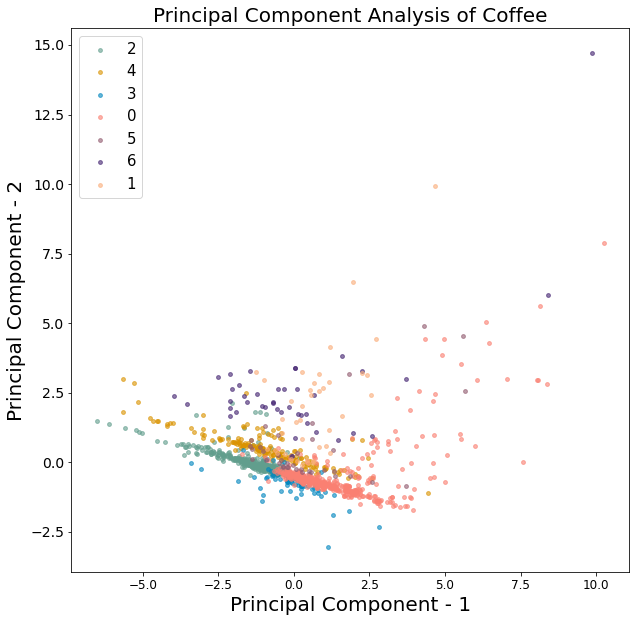

In [40]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Coffee",fontsize=20)
targets = list(agglom_df.cluster.unique())
colors = ['#619e8d','#da9300','#0086bf','#fa8072','#925c70','#432371',"#FAAE7B"] # ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = agglom_df['cluster'] == target
    plt.scatter(pca_df.loc[indicesToKeep.values, 'princ_comp1'],
                pca_df.loc[indicesToKeep.values, 'princ_comp2'], 
                c = color, s = 15, alpha=0.6)

plt.legend(targets,prop={'size': 15})

The graph for the first 2 components shows that there is a lot of overlapping in the middle, however, **clusters 0, 1, 2, 4, and 6** seem to have some defined regions, while the **clusters 3 and 5** have more overlap with the others.

#### Plot recommended coffees

In [41]:
recomm_df['Target'] = 'Marcio+Rafa'
recomm_df2['Target'] = 'Subu'
recomm_df3['Target'] = 'James'
all_recomm_df = pd.concat([recomm_df,recomm_df2,recomm_df3],
                          ignore_index=True, sort=False)
all_recomm_df

,Unnamed: 0,Ranking,Species,Owner,Country.of.Origin,Farm.Name,Lot.Number,Mill,ICO.Number,Company,...,Color,Category.Two.Defects,Expiration,Certification.Body,altitude_low_meters,altitude_high_meters,altitude_mean_meters,cluster,train_idx,Target
0,1375,1,Arabica,byron gonzalez,Guatemala,alta luz,415000544,NaN,11-63-1073,"retrillas del pacifico, s. a.",...,Green,5 full defects,"July 20th, 2021",Asociacion Nacional Del Café,1400.00,1400.00,1400.00,3,1141,Marcio+Rafa
1,1369,2,Arabica,angelica paola citan lopez,Guatemala,finca beneficio el torreon,11/23/267,beneficio ixchel,11/23/267,asociación nacional del cafe,...,Green,4 full defects,"March 19th, 2022",Asociacion Nacional Del Café,1901.00,1901.00,1901.00,3,1135,Marcio+Rafa
2,262,3,Arabica,ipanema coffees,Brazil,capoeirinha,007/16E,dry mill,002/1660/0105,ipanema coffees,...,Green,7,"August 16th, 2017",Brazil Specialty Coffee Association,934.00,934.00,934.00,3,209,Marcio+Rafa
3,319,4,Arabica,ipanema coffees,Brazil,capoeirinha,008/16A,dry mill,002/1660/0106,ipanema coffees,...,Green,3,"August 16th, 2017",Brazil Specialty Coffee Association,934.00,934.00,934.00,3,256,Marcio+Rafa
4,481,5,Arabica,ipanema coffees,Brazil,capoeirinha,261/15,dry mill,002/1660/0049,ipanema coffees,...,Bluish-Green,2,"April 25th, 2017",Brazil Specialty Coffee Association,905.00,905.00,905.00,3,390,Marcio+Rafa
5,602,1,Arabica,romulo bello flores,Mexico,NaN,NaN,NaN,1302910536,cafe shunuc,...,NaN,4,"June 6th, 2013",AMECAFE,1200.00,1200.00,1200.00,1,493,Subu
6,556,2,Arabica,veronica lopez castillejos,Mexico,el jabali,NaN,comunidad la cumbre,1489,union de ejidos san fernando de ri,...,Green,4,"March 5th, 2013",AMECAFE,1400.00,1400.00,1400.00,1,451,Subu
7,520,3,Arabica,santiago solis ayerdi,Mexico,finca la estancia,NaN,"atoyac de alvarez, guerrero",1302911347,finca la estancia,...,Green,7,"July 26th, 2013",AMECAFE,1200.00,1200.00,1200.00,1,423,Subu
8,713,4,Arabica,ipanema coffees,Brazil,rio verde,NaN,ipanema coffees,002/1660/0107,ipanema coffees,...,Green,0,"October 7th, 2016",Specialty Coffee Association,1268.00,1268.00,1268.00,1,583,Subu
9,1076,5,Arabica,jacques pereira carneiro,Brazil,pereira estate coffee,NaN,carapina armazens gerais,002/135-2/0182,exportadora de cafés carmo de minas ltda,...,None,10,"April 17th, 2015",Specialty Coffee Association,1250.00,1250.00,1250.00,1,893,Subu


<Figure size 432x288 with 0 Axes>

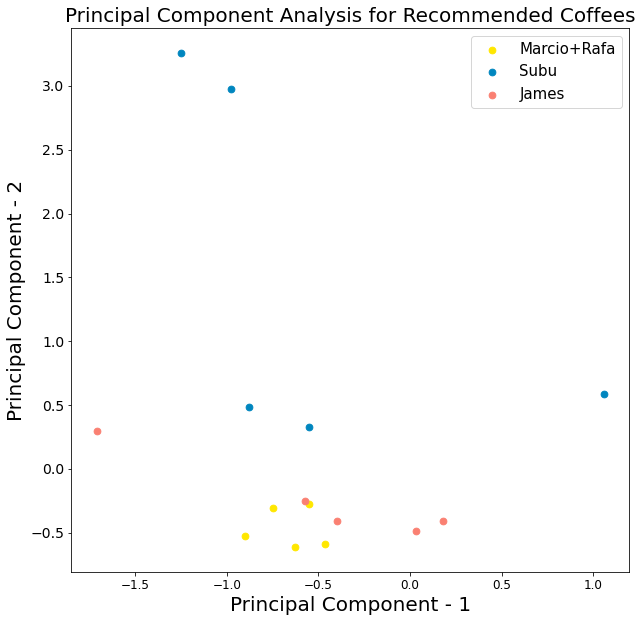

In [42]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis for Recommended Coffees",fontsize=20)
targets = ['Marcio+Rafa', 'Subu', 'James']
colors = ['#ffe700','#0086bf','#fa8072'] # ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = all_recomm_df[all_recomm_df['Target'] == target].train_idx.values
    plt.scatter(pca_df.loc[indicesToKeep, 'princ_comp1'],
                pca_df.loc[indicesToKeep, 'princ_comp2'], 
                c = color, s = 45, alpha=1)

plt.legend(targets,prop={'size': 15})

The plot of the first 2 principal components shows that the recommendations for Marcio and Rafa are very close to each other while Subu's recommendations seem to have a separate region but are more spread. Finally, James recommendations present some overlapping with Marcio's group. However, this results need to be carefully considered because as it was seen before, the first 2 components are explaining just around 46% of the variation in the data, and are used to have a visual idea of the clusters.

### Conclusion and Final comments
This task has focused on the following parts:

**1. Scrapping data for Robusta and Arabica coffee**  
**2. Cleaning the scrapped data**  
**3. Join new data with previously cleaned data**  
**4. Classification and clustering of the different coffee types:** Two different algorithms were evaluated, K-means and Hierarchical clustering (agglomerative). Since validating the quality of the clustering is a challenging task (silhouette score was not a successful metric), a new metric was implemented where the algorithm producing the highest percentage of *Sul de Minas* coffees in a single cluster was selected.  
**5. Recommendations for different coffee preferences:** After selecting the clustering algorithm, the top 5 coffees were recommended for each preferences profile. Different metrics like *Region, Sweetness, Aroma, etc* were used to find the best cluster and specific coffees to recommend.  
**6. PCA for visualization:** Using the first 2 principal components, the clusters were visualized, as well as the coffees recommended to each of the members of the team. (It is important to consider that the first 2 components account for around 46% of the variability in the dataset, and they were mainly used for visualization purposes)

Finally two limitations that may be addressed for the future are:
* Mixing categorical data with continuous is not easy task in clustering, one could use one-hot encoding to include for example the Region which is important for the task, and perhaps look for a mixed approach with K-modes, however, the dimensionality would increase considerably by including all the one-hot encoded variables from Region and finding clusters in such a big dimension space can be very difficult, specially for the limited amount of data available (around 1.5K observations). Can a different approach be used for including the region variable, like a one-hot encoding that groups several regions together?
* Given the limitations of the data set, a future approach to consider could be some dimensionality reduction method like PCA as a way to create more dense regions with the clustering algorithms.